# Data Visualizations

This notebook covers data visualization of training data. 

### Importing libraries and data

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
import seaborn as sns
from sklearn.decomposition import PCA
from yellowbrick.features import PCA as PCA_viz
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

from matplotlib import pyplot as plt
%matplotlib inline
seed = 73

In [75]:
df = pd.read_csv('occupied_features_withincome.csv')

In [121]:
len(df.columns)

83

### Distributions of Features of Interests 

First, we will look at distributions of certain features of interests to get a general idea of what we are working with. 

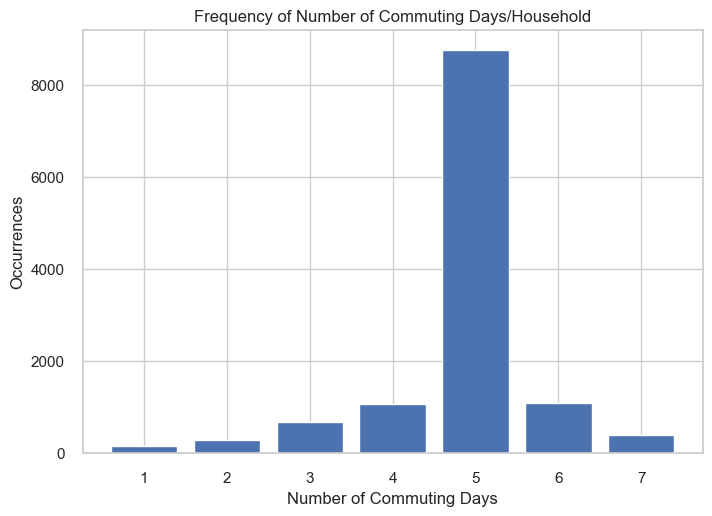

In [99]:
# Get value counts for commuting days and plot with matplotlib
comdays_counts = df['COMDAYS'].value_counts()
plt.bar(comdays_counts.index, comdays_counts.values)

# Adding labels
plt.xlabel('Number of Commuting Days')
plt.ylabel('Occurrences')
plt.title('Frequency of Number of Commuting Days/Household')

# Display the plot
plt.show()

If the householder is commuting, the vast majority commute for 5 days - the length of a typical workweek. 


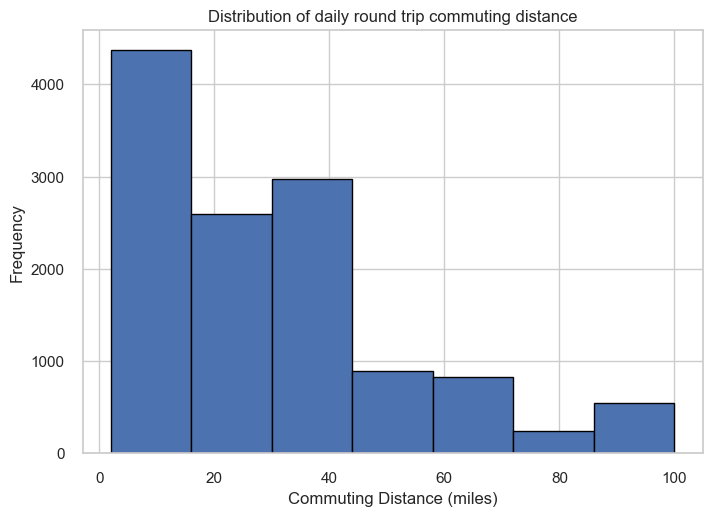

In [101]:
# Plot histogram for commuting distance
plt.hist(df['DIST'], bins=7, edgecolor='black') 
plt.xlabel('Commuting Distance (miles)')
plt.ylabel('Frequency')
plt.title('Distribution of daily round trip commuting distance')
plt.grid(True)

# Display the plot
plt.show()

* Note that any commuting distance over 100 miles is listed as 100. 
* Most people commute within 40 miles to and from work. This is about an hour if you drive 40 mph, which makes sense. 
* However, there is a good amount of people who commute up to 100 - this is also reasonable. 

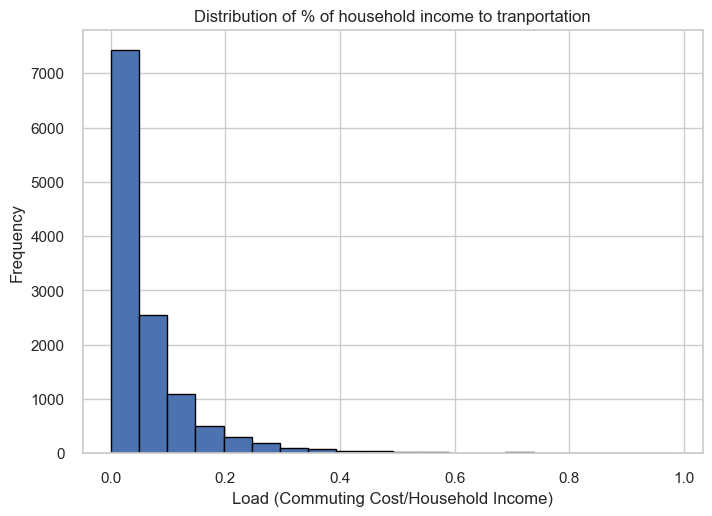

In [102]:
# Plot histogram for load
plt.hist(df['load'], bins=20, edgecolor='black')  
plt.xlabel('Load (Commuting Cost/Household Income)')
plt.ylabel('Frequency')
plt.title('Distribution of % of household income to tranportation')
plt.grid(True)

# Display the plot
plt.show()

Majority of households only spent 0% to 5% of their household income on commuting costs. 

### Correlations between Features of Interests

Now that we have an idea of how some of the features of interest are distributed, we can now look at if there's any relationships between them. This will be helpful for a couple of reasons:
1. Tells us which features are likely to be important in predictive modelling. 
2. Feature engineering - we may be able to remove a certain feature if it's highly correlated with another. 
3. For bias and equity reasons - to see if some demographic variables can be reconstructed in a way that reinforces any existing biases. 

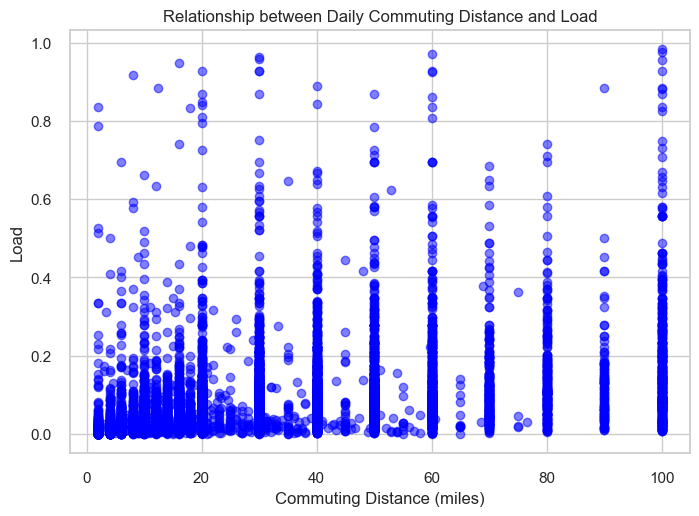

In [103]:
# Plotting scatter plot
plt.scatter(df['DIST'], df['load'], color='blue', alpha=0.5) 
plt.xlabel('Commuting Distance (miles)')
plt.ylabel('Load')
plt.title('Relationship between Daily Commuting Distance and Load')
plt.grid(True)

# Display the plot
plt.show()

I expected that load would be correlated with commuting distance, as longer commuting distance = more gasoline costs. However, it doesn't seem to be the case given the scatter in the plot above. 

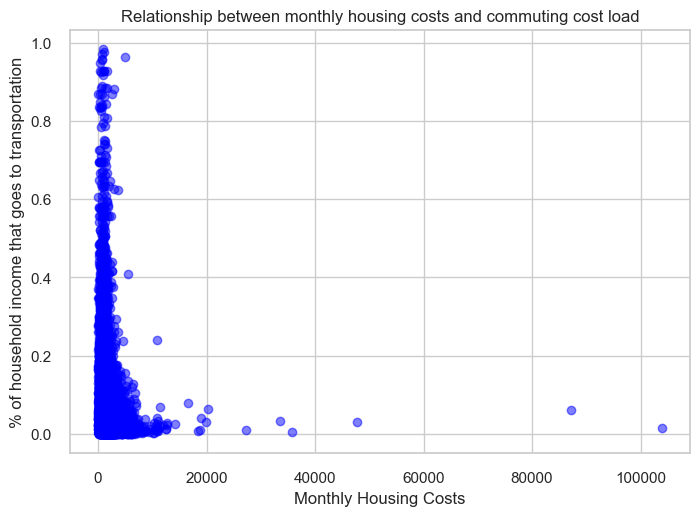

In [109]:
# Plotting scatter plot
plt.scatter(df['TOTHCAMT'], df['load'], color='blue', alpha=0.5)  
plt.xlabel('Monthly Housing Costs')
plt.ylabel('% of household income that goes to transportation')
plt.title('Relationship between monthly housing costs and commuting cost load')
plt.grid(True)

# Display the plot
plt.show()

It seems like people who have lower commuting cost loads have higher monthly housing costs. This makes sense because if you can afford an expensive house, you're usually extremely wealthy, and any amount of transportation is trivial compared to your entire budget. 

### Comparing Groups with Boxplots

There are a lot of categorical and dummy variables in this dataset. Let's explore how these groups differ. 

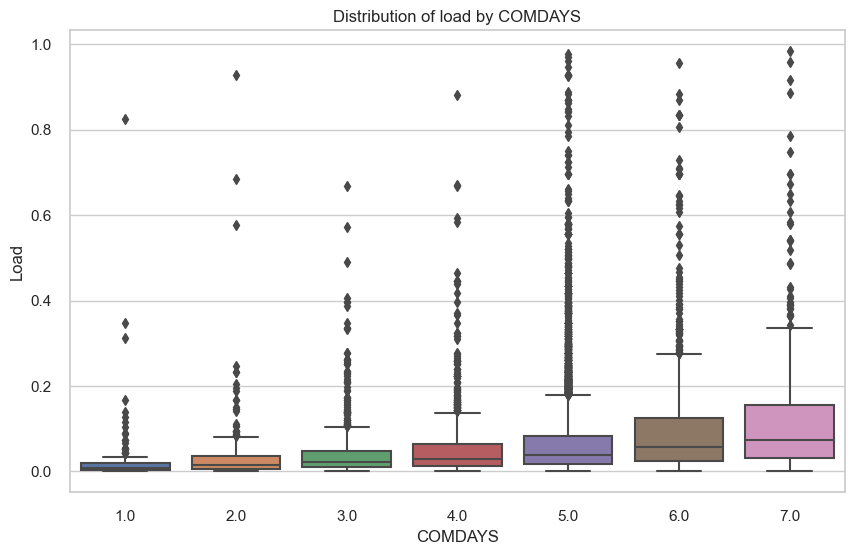

In [110]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='COMDAYS', y='load', data=df)
plt.title('Distribution of load by COMDAYS')
plt.xlabel('COMDAYS')
plt.ylabel('Load')

# Show the plot
plt.show()

As the number of commuting days increase, the distributions of commuting cost load increases. This makes sense - the more you commute, the greater your commuting costs will be, and the greater the % load. Also, people who have to commute into work every day often work lower-paying jobs, which would also increase the % load. 

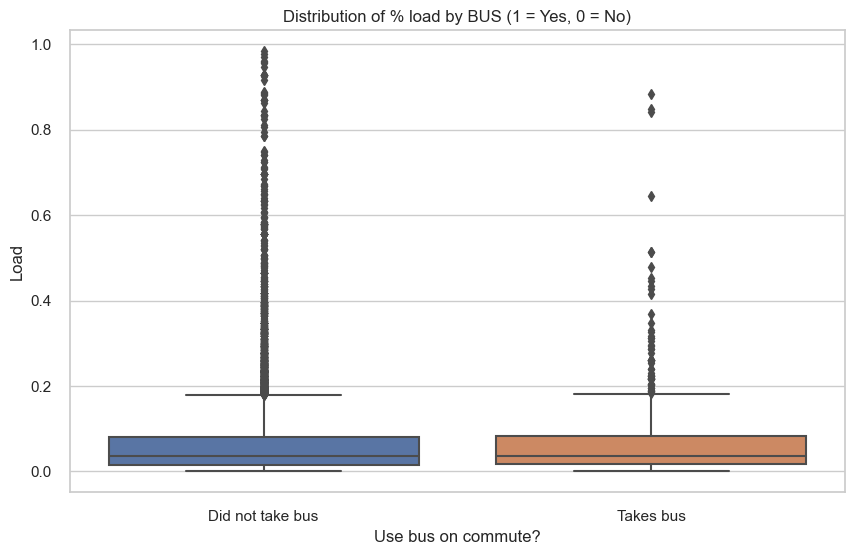

In [118]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='BUS_YES', y='load', data=df)
plt.title('Distribution of % load by BUS (1 = Yes, 0 = No)')
plt.xlabel('Use bus on commute?')
plt.xticks(ticks=[0, 1], labels=['Did not take bus', 'Takes bus']) 
plt.ylabel('Load')

# Show the plot
plt.show()

Interestingly, whether someone takes the bus or not does not seem to affect the % load. 

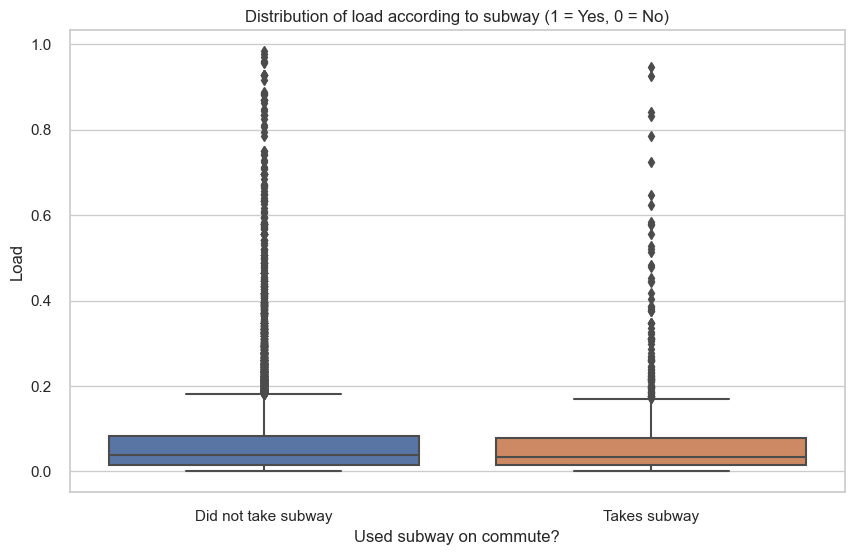

In [119]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='SUBWAY_YES', y='load', data=df)
plt.title('Distribution of load according to subway (1 = Yes, 0 = No)')
plt.xlabel('Used subway on commute?')
plt.xticks(ticks=[0, 1], labels=['Did not take subway', 'Takes subway']) 
plt.ylabel('Load')

# Show the plot
plt.show()

Same thing for subway!

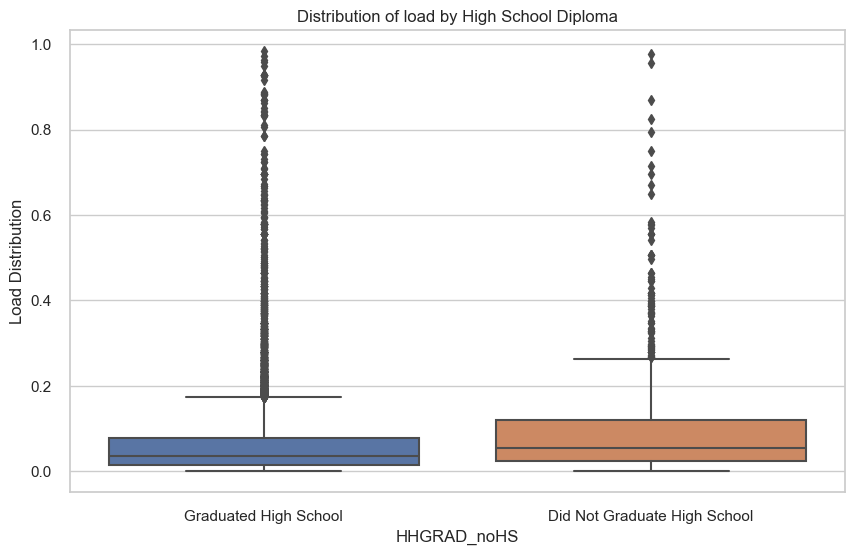

In [120]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='HHGRAD_noHS', y='load', data=df)
plt.title('Distribution of load by High School Diploma')
#plt.xlabel('No High School')
plt.xticks(ticks=[0, 1], labels=['Graduated High School', 'Did Not Graduate High School']) 
plt.ylabel('Load Distribution')

# Show the plot
plt.show()

This is interesting. Those who did not graduate high school probably have lower-paying jobs, which would increase % load, which results in the graph above where the distribution is slightly higher than those who did graduate high school. 

### Correlation matrices

Let's now try some correlation matrices. Since there are 82 columns, it would be difficult to interpret 82 x 82 matrix. Therefore, we will select certain variables and group it into chunks -> demographic features & financial/commute related features.

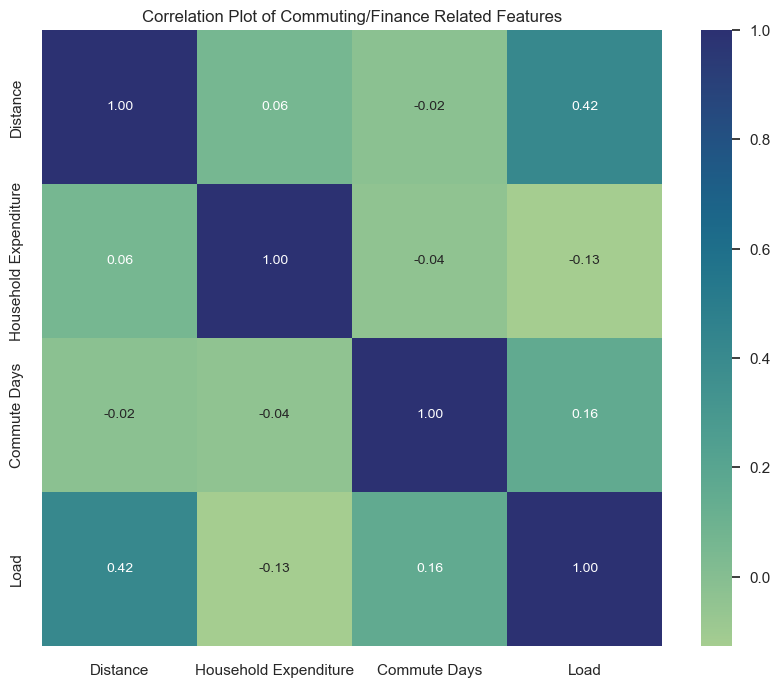

In [87]:
# Select the specific features you want to include
selected_features = ['DIST', 'TOTHCAMT', 'COMDAYS', 'load']

# Extract the subset of the DataFrame with only the selected features
selected_df = df[selected_features]
selected_df.columns = ['Distance', 'Household Expenditure', 'Commute Days', 'Load']

# Calculate the correlation matrix
correlation_matrix = selected_df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Plot of Commuting/Finance Related Features')
plt.show()

Distance and load seem to be most correlated, which is not expected given the scatter plot above. The rest are pretty unrelated to each other. 

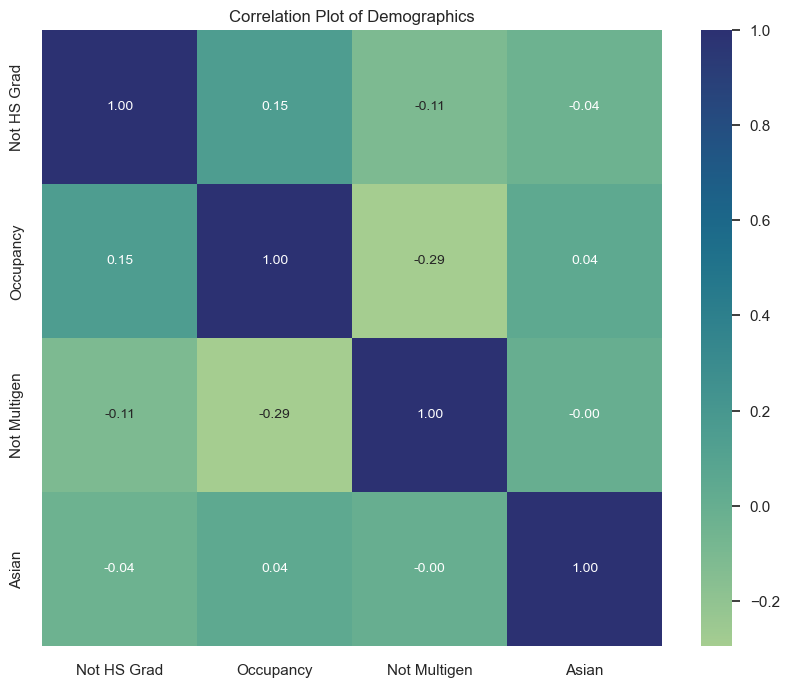

In [91]:
# Select the specific features you want to include
selected_features = ['HHGRAD_noHS', 'NUMPEOPLE', 'MULTIGEN_NotMulti', 'HHRACE_Asian']

# Extract the subset of the DataFrame with only the selected features
selected_df = df[selected_features]
selected_df.columns = ['Not HS Grad', 'Occupancy', 'Not Multigen', 'Asian']
# Calculate the correlation matrix
correlation_matrix = selected_df.corr()


# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Plot of Demographics')
plt.show()

Other that not_multigen and occupancy (which makes sense, the higher the occupancy, the less likely that a household is not multigen), there does not seem to be a relationship between the demographics. 

## Conclusions for Data Visualization

Remember earlier we said that this data visualization exercise will help us with: 
1. Tells us which features are likely to be important in predictive modelling. 


Commuting distance will probably be important. Perhaps education as well. 

2. Feature engineering - we may be able to remove a certain feature if it's highly correlated with another. 


No variables seem to be highly correlated with each other. 

3. For bias and equity reasons - to see if some demographic variables can be reconstructed in a way that reinforces any existing biases. 


The demographic variables we looked at don't really have any relation to each other. This needs further testing because we only tested a few - but it does help us feel better about there being less biases in the training data. 